In [5]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline


In [6]:
from PreproccessPipeline import *


data = pd.read_csv('data/adult.csv')
data["class"] = data["class"].str.strip().str.lower() == "<=50k"

cat = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']

continuous_features = [
    'age',
    'fnlwgt',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'education-num'
]

# pipeline = PreproccessPipeline(continuous=continuous_features,
#                                categories=cat, className="class")

# data = pipeline.fit_transform(data)

print(data.head())

# data = pipeline.labelDecode(data)
data.head()


   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  class  
0          2174             0              40   United-States   True 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,True
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,True
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,True
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,True
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,True



Splitting data into training / test allows me to test the accuracy of my model on unseend data.

this split is random however to mainatin class raitios i have used stratisfied sampling.

random state = 1 allows randomisation to remain deterministic, this ensures that test data dos not bleed into the training data

In [7]:
from imblearn.over_sampling import SMOTE

X = data.drop(['class'], axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

print(y_train.value_counts())


True     19775
False     6273
Name: class, dtype: int64


In [8]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# print(data.head())

print(data.info(verbose=1))

model = MLPClassifier(random_state=1,
        max_iter=700,
        activation="relu",
        hidden_layer_sizes=(100, 100, 100, 100),
        verbose=True,
        solver="adam"
)


sm = SMOTE()
# X_train, y_train = sm.fit_resample(X_train, y_train)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', model)])
 


trainedModel = clf.fit(X_train, y_train)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  bool  
dtypes: bool(1), int64(6), object(8)
memory usage: 3.5+ MB
None
Iteration 1, loss = 0.40038297
Iteration 2, loss = 0.36261078
Iteration 3, loss

/Users/alexvarden/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
import pickle

filename = "models/adult-nn-pipe.pickle"
pickle.dump(trainedModel, open(filename, "wb"))


Multiclass classification requires One verses Rest in order to compare ROC_AUC 

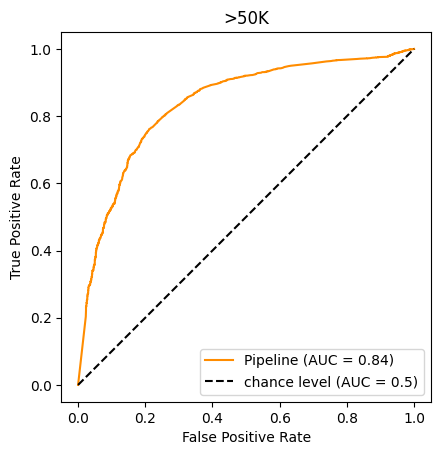

In [ ]:
y_score = trainedModel.predict_proba(X_test)

RocCurveDisplay.from_estimator(
    trainedModel,
    X_test, y_test,
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f">50K")
plt.legend()
plt.show()
